In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.data import data_collection

In [500]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
DBNAME = "opportunity_youth"

In [9]:
conn = psycopg2.connect(dbname=DBNAME)

In [403]:
#Filtered the 2017 pums to select from south king county region, Age 16-24, not have a job and not in school. 
#There are the areas we chose because we figured they had a larger amount of OY and its a part of what the origonal data included
#Auburn,Federal Way, Highline, Kent, Renton, (South) Seattle, and Tukwila was what the origonal data included. 
df1 = pd.read_sql('''SELECT * 
FROM pums_2017
WHERE puma IN ('11612','11613','11614','11615','11604', '11610', '11611')
AND agep BETWEEN '16' AND '24'
AND cow = '9'
AND fschp = '0'
;''', conn)

In [468]:
#a list of the estimated population by each region and the total population for all 7 regions
population = df1.groupby('puma')['pwgtp'].sum()   # pwgtp was the weight each person held I grouped by the puma then took the sum of the pwgtp per each puma
estimated_population = sum(population)
estimated_population

2105.0

In [508]:
df1.head()

,rt,serialno,division,sporder,puma,region,st,adjinc,pwgtp,agep,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,2013000188706,9,03,11604,4,53,1061971,29.0,19.0,...,29.0,40.0,13.0,10.0,44.0,34.0,42.0,57.0,31.0,7.0
1,P,2013000179295,9,03,11612,4,53,1061971,74.0,16.0,...,115.0,27.0,25.0,59.0,49.0,133.0,136.0,26.0,68.0,103.0
2,P,2013000208643,9,04,11615,4,53,1061971,17.0,18.0,...,30.0,5.0,15.0,16.0,6.0,16.0,17.0,4.0,15.0,16.0
3,P,2013000220663,9,03,11615,4,53,1061971,14.0,22.0,...,4.0,12.0,24.0,4.0,22.0,13.0,12.0,16.0,14.0,13.0
4,P,2013000354307,9,04,11604,4,53,1061971,73.0,20.0,...,85.0,73.0,97.0,97.0,27.0,25.0,29.0,71.0,118.0,101.0


In [495]:
# dictionary of Puma number, name of it and population based on weighted amount. 
region_dic = {'11612': ['Federal Way,Des moines Cities & Vashon island', population['11612']], 
 '11604': ['South East Seattle', population['11604']],
 '11615': ['Maple Valley, Covingtion and Enumclaw Cities',population['11615']],
 '11614': ['Auburn City & Lakeland', population['11614']],
 '11613': ['Kent City',population['11613']],
 '11611': ['Burien, SeaTac, Tukwita Cities',population['11611']],
 '11610': ['Renton City, Fiarwood, Bryn Mawr and Skyway', population['11610']]}
region_dic

{'11612': ['Federal Way,\n Des moines Cities & Vashon island', 498.0],
 '11604': ['South East Seattle', 366.0],
 '11615': ['Maple Valley, Covingtion and Enumclaw Cities', 356.0],
 '11614': ['Auburn City & Lakeland', 309.0],
 '11613': ['Kent City', 262.0],
 '11611': ['Burien, SeaTac, Tukwita Cities', 202.0],
 '11610': ['Renton City, Fiarwood, Bryn Mawr and Skyway', 112.0]}

In [457]:
city_list = [item[0] for item in region_dic.values()]  # created a list of the cities based on the region_dic 
estimated_population_region = [item[1] for item in region_dic.values()] # created a listed of the estimated population per region

In [496]:
# adjusted city list so the string is on muliple lines in the graph
city_list_adj = [sub.replace(',',',\n') for sub in city_list]

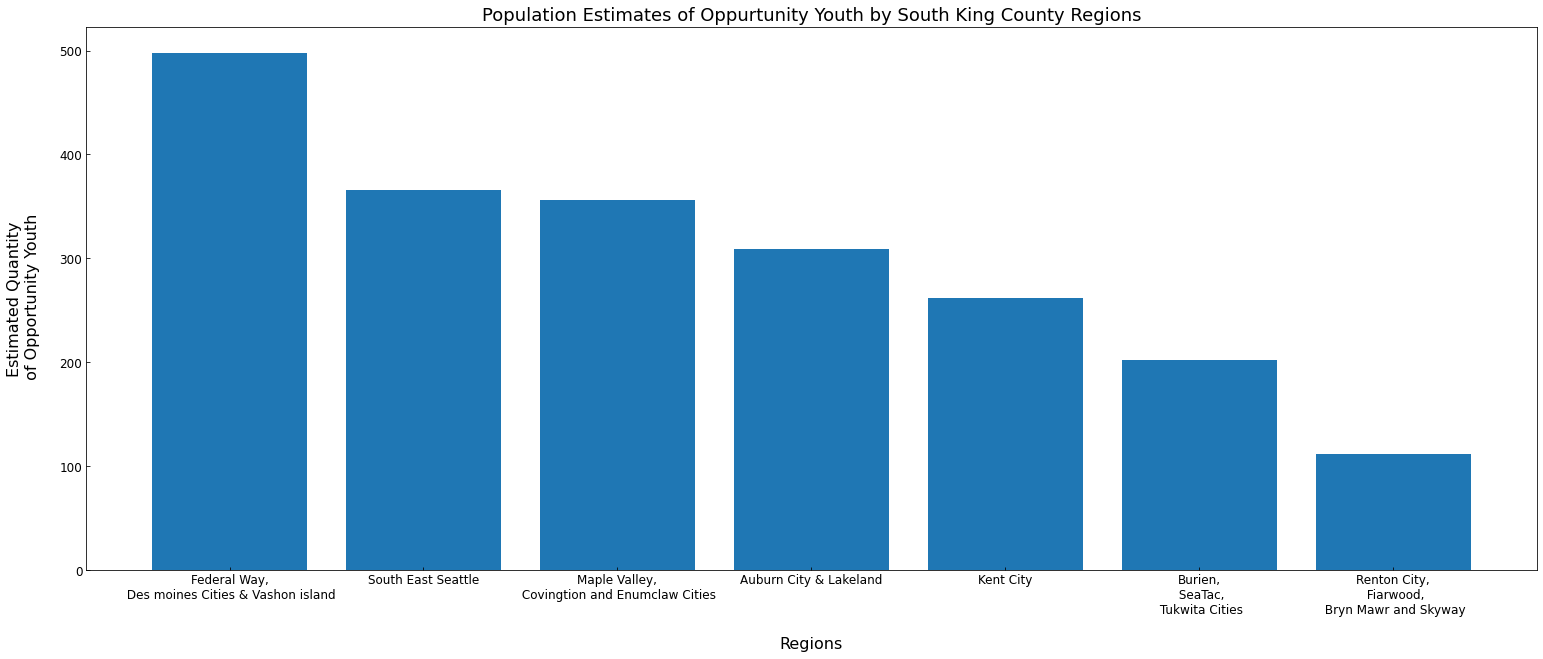

In [501]:
#Printing a Bar graph of the population estimate per each puma(region)
figure, ax = plt.subplots(1, 1, figsize = (26,10));

x = city_list_adj;
y = estimated_population_region;
ax.bar(x, y);


ax.set_ylabel('Estimated Quantity\n of Opportunity Youth', fontsize = 16, rotation = 90, labelpad = 20);
ax.set_xlabel('Regions', fontsize = 16, labelpad = 20);
ax.set_title('Population Estimates of Oppurtunity Youth by South King County Regions', fontsize = 18);
ax.set_xticklabels(city_list_adj, wrap = True);
ax.tick_params(axis='both', which='major', labelsize=12, direction = 'in')
                   